# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



### Step 1 - Lets load each file, and explore the dataset.

In [21]:
import pandas as pd

# Load datasets
alldata = pd.read_excel('alldata.xlsx')
drdata = pd.read_excel('drdata.xlsx')
drq = pd.read_excel('drq.xlsx')
electeddata = pd.read_excel('electeddata.xlsx')
tv2data = pd.read_excel('tv2data.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')

# Display column names to get sense of the data.
print(alldata.columns)
print(drdata.columns)
print(drq.columns)
print(tv2data.columns)
print(tv2q.columns)
print(electeddata.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b', 'storkreds',
       'alder'],
      dtype='object')
Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti'],
      dtype='object')
Index(['ID', 'Title', 'Question', 'Info', 'ArgumentFor', 'ArgumentAgainst',
       'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'],
      dtype='object')
Index(['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b',
       '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a',
  

Let's wait to clean before we understand the data better - This approach ensures that we don’t accidentally lose valuable information.


### Step - 2 Create a combined questions series 

In [22]:
# Align IDs and questions from DR and TV2 for extraction and combination
# Rename 'ID' in drq to match 'id' in tv2q, then set 'id' as index for both
dr_id_question_series = drq.rename(columns={'ID': 'id', 'Question': 'question'}).set_index('id')['question']
tv2_id_question_series = tv2q.set_index('id')['question']

# Concatenate questions from DR and TV2 into a single series
questions = pd.concat([dr_id_question_series, tv2_id_question_series])

# Display the combined questions for verification
questions

id
530    Danmark skal bruge flere penge på at styrke to...
531    Der skal indføres en særlig skat på de allerhø...
533    Kriminalitet begået i udsatte boligområder ska...
534                 På sigt skal Danmark meldes ud af EU
535    Det er fornuftigt, at Danmark i de kommende år...
                             ...                        
10b    Den såkaldte Arne-pension, der giver mulighed ...
11a    Der har været alt for meget fokus på Mette Fre...
11b    Det bør undersøges, om Mette Frederiksen kan s...
12a    Hvis coronasmitten stiger markant til vinter, ...
12b    Hvis coronasmitten stiger markant til vinter, ...
Name: question, Length: 99, dtype: object

In [23]:

type(dr_id_question_series)

pandas.core.series.Series

Why use series ?
- It simplifies operation when you only need to work with one column.
- Lighter, and easier to work with
- You can easliy apply functions to all values

### Step - 3 Let's translate the questions into English.

In [24]:
from googletrans import Translator

translator = Translator()

def translate_text(text):
    try:
        # Translate from Danish to English
        translation = translator.translate(text, src='da', dest='en')
        return translation.text
    except Exception as e:
        print(f"Error translating text: {text} - {e}")
        return text

# Apply translation function to the Series
questions_english = questions.apply(translate_text)

print(questions_english)

Error translating text: Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje - 'NoneType' object has no attribute 'group'
Error translating text: Der skal indføres en særlig skat på de allerhøjeste indkomster - 'NoneType' object has no attribute 'group'
Error translating text: Kriminalitet begået i udsatte boligområder skal straffes særligt hårdt - 'NoneType' object has no attribute 'group'
Error translating text: På sigt skal Danmark meldes ud af EU - 'NoneType' object has no attribute 'group'
Error translating text: Det er fornuftigt, at Danmark i de kommende år bruger markant flere penge på forsvaret - 'NoneType' object has no attribute 'group'
Error translating text: Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere - 'NoneType' object has no attribute 'group'
Error translating text: Forældres indkomst skal være et af kriterierne for fordeling af elever i gymnasiet - 'NoneType' object has no attribute 'g

### Step - 4 Seprate Answers from Segments

Why are we even doing this ?


In [25]:
# We select columns based on whether they match a question ID from the questions index.
answers = alldata[alldata.columns[alldata.columns.astype(str).isin(questions.index.astype(str))]]

# segments now contains all columns that are not answers meaniing rest of the metadata.
segments = alldata.drop(answers.columns, axis=1)

print(answers.columns)
print(segments.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', '1a', '1b', '2a', '2b', '3a', '3b',
       '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a', '8b', '9a', '9b',
       '10a', '10b', '11a', '11b', '12a', '12b'],
      dtype='object')
Index(['navn', 'parti', 'storkreds', 'alder'], dtype='object')


Why are we even doing this ?
By selecting columns based on whether they match a question ID from the questions series, we seprat the answers columns from rest of the meta data which we are calling segments here.

- Answer column now contains only columns with question IDs: This will make it easier to focus on statistical patterns in responses without involving metadata.

### Step - 6 Do we have any missing answers ?

In [26]:
# Calculate missing values per question
missing_answers_count = answers.isnull().sum()
missing_answers_count = missing_answers_count[missing_answers_count > 0].sort_values(ascending=False)
print("Questions with Missing Values:", missing_answers_count)

# Check for rows where all answers are missing or zero (assuming zero indicates missing answers)
missing_all_zeros = answers.eq(0).all(axis=1).sum()
print("Rows with all-zero answers:", missing_all_zeros)


Questions with Missing Values: Series([], dtype: int64)
Rows with all-zero answers: 0


No questions have Missing values or no rows where all answer columns are zero.

 Likert scale values already have meaningful order, so no scaling is necessary here.

### Step - 7 Let's combine the Translated questions with the answers above

In [27]:

#Lets create a copy so we don't modify the original data.
questions_answers = answers.copy() 

#  select elements from english qustions series that are in the answers columns, and rename the columns to the english questions.
questions_answers.columns = questions_english[questions_english.index.astype(str).isin(questions_answers.columns.astype(str))] 

# print a few
questions_answers.head()



question,Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje,Der skal indføres en særlig skat på de allerhøjeste indkomster,Kriminalitet begået i udsatte boligområder skal straffes særligt hårdt,På sigt skal Danmark meldes ud af EU,"Det er fornuftigt, at Danmark i de kommende år bruger markant flere penge på forsvaret","Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere",Forældres indkomst skal være et af kriterierne for fordeling af elever i gymnasiet,Det skal være muligt at tjene penge på at drive private børnehaver og vuggestuer,Der skal indføres skat på fortjenesten ved salg af bolig,"Det er en god idé, at dagpengesatsen for nyuddannede er sat ned",...,"Der skal tilføres markant flere ressourcer til psykisk sårbare unge, selvom dette vil medføre, at andre velfærdsområder får færre ressourcer.","Der bør tilføres ekstra ressourcer til pasning af de mindste børn, selvom dette vil medføre, at andre velfærdsområder får færre ressourcer.",Dele af SU’en på videregående uddannelser skal omdannes til lån for at sikre ressourcer til andre dele af uddannelsesområdet.,"Skolerne skal i højere grad hjælpe særligt udfordrede børn, også selvom det vil ske på bekostning af hjælpen til de øvrige elever.","Det offentlige bruger i dag for mange penge på at hjælpe mennesker, der godt kunne klare sig selv, og for få penge på mennesker, der virkelig har brug for hjælp.","Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.",Der har været alt for meget fokus på Mette Frederiksens håndtering af Mink-sagen – under omstændighederne gjorde hun det rigtige.,"Det bør undersøges, om Mette Frederiksen kan stilles for en rigsret som konsekvens af hendes håndtering af Mink-sagen.","Hvis coronasmitten stiger markant til vinter, skal samfundet holdes mest muligt åbent, også selvom det kan koste menneskeliv.","Hvis coronasmitten stiger markant til vinter, skal regelmæssige tests være et krav for de uvaccinerede personer i Danmark."
0,-1,-2,1,-2,2,1,-2,1,1,2,...,1,0,2,0,1,-2,-2,1,1,1
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,0,0,-2,0,-1,2,1,-2,0,0
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,1,1,-1,-2,0,2,0,-1,1,-2
3,2,1,-2,-1,1,1,1,1,1,-2,...,2,2,-2,2,2,2,2,-1,2,0
4,1,1,-2,2,-2,1,-2,1,2,-2,...,1,0,-2,0,-1,0,-2,0,2,-2


### Step 8 - Which questions are most crutial ? Let's check for variance.

In [28]:
# Calculate variance for each questiona
question_variances = questions_answers.var().sort_values(ascending=False)

# Display top questions with the highest variance
print("Top Variance Questions:\n", question_variances.head())

Top Variance Questions:
 question
Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles                               2.752703
Den såkaldte Arne-pension skal afskaffes                                                                                       2.710888
Danmark skal undersøge muligheden for at udvikle A-kraft som energikilde herhjemme                                             2.632589
Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.    2.611274
Der skal indføres en særlig skat på de allerhøjeste indkomster                                                                 2.611109
dtype: float64


### Step 9 - Let's figure out average positions of parties for each question

In [29]:
# Join the segments DataFrame to include party information
questions_answers_with_party = questions_answers.join(segments['parti'])

# Calculate the average response per party for each question
party_averages = questions_answers_with_party.groupby('parti').mean()

# Display the results for verification
print("Average Responses by Party:\n", party_averages.head())


Average Responses by Party:
                              Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje  \
parti                                                                                                                       
Alternativet                                                          1.880597                                              
Danmarksdemokraterne                                                 -0.837838                                              
Dansk Folkeparti                                                     -0.571429                                              
Det Konservative Folkeparti                                          -0.836735                                              
Enhedslisten                                                          1.959459                                              

                             Der skal indføres en særlig skat på de allerhøjeste indkomster  \


Lets plot it using party colors - But lets only focus on the questions previously considered crutial based on the variance.

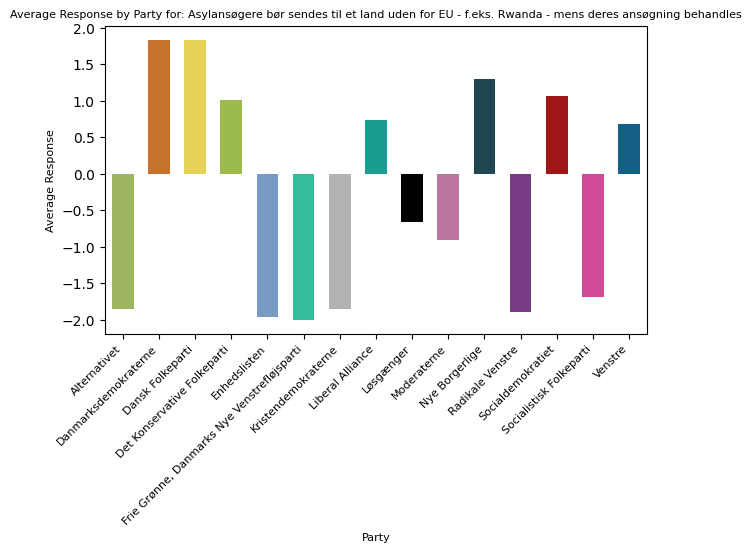

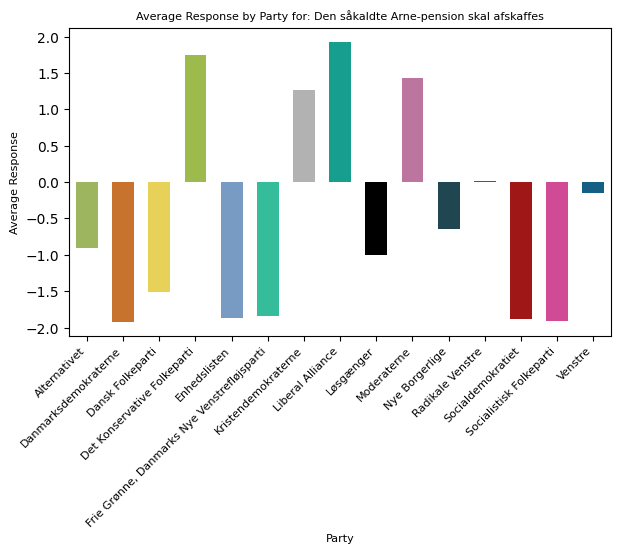

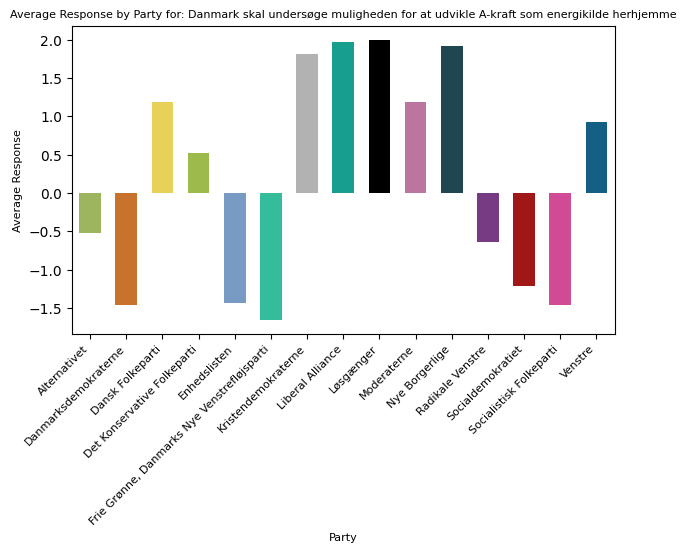

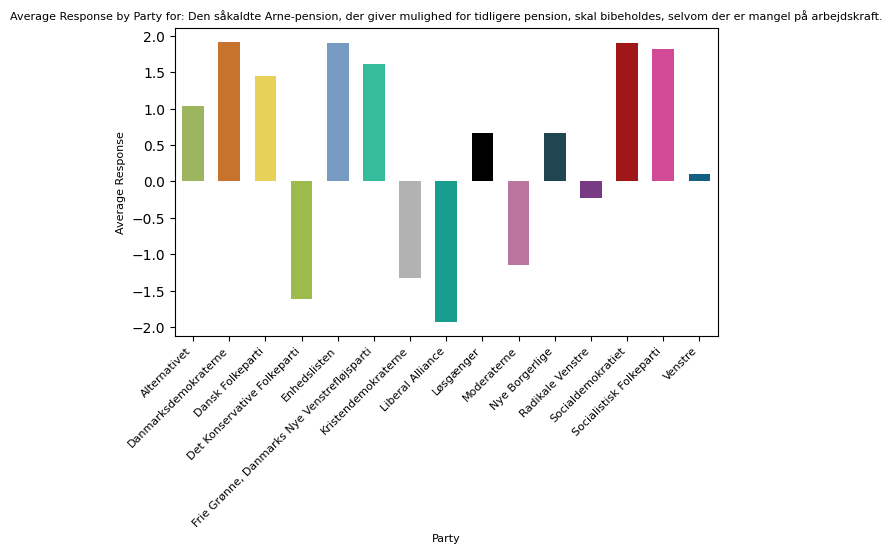

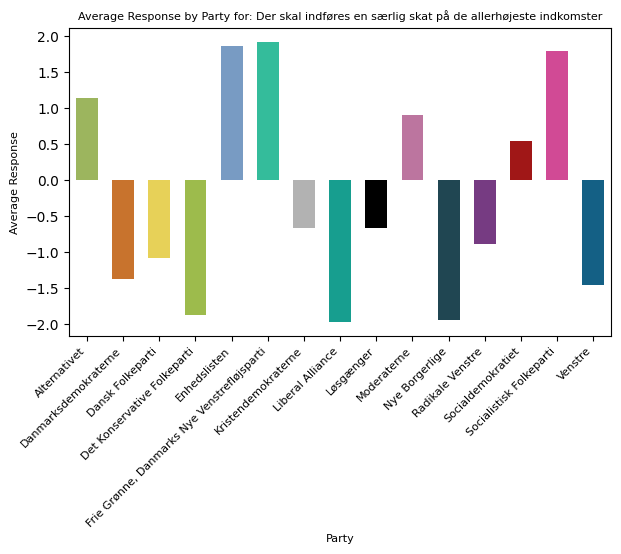

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

party_colors = {
    'Socialdemokratiet': '#B70000',
    'Radikale Venstre': '#7E2F8E',  
    'Konservative': '#A6CE39',  
    'Nye Borgerlige': '#174A5B',  
    'Socialistisk Folkeparti': '#E73498',  
    'Liberal Alliance': '#00B4A0',  
    'Kristendemokraterne': '#B2B2B2',  
    'Moderaterne': '#C869A1',
    'Dansk Folkeparti': '#FFE140', 
    'Frie Grønne': '#1DD3A7',  
    'Venstre': '#016798', 
    'Enhedslisten': '#6B9ACF',  
    'Danmarksdemokraterne': '#E27113', 
    'Alternativet': '#A2C350',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': '#1DD3A7',
    'Det Konservative Folkeparti': '#A6CE39',
    'Løsgænger': '#000000'
}

# Lets get the top crucial questions found earlier.
top_crutial_questions = question_variances.head(5).index

# Plot each question's average by party with above colors
for question in top_crutial_questions:
    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=party_averages.reset_index(),
        x='parti',
        y=question,
        hue='parti',
        palette=party_colors,
        dodge=False,
        width=0.6,
        legend=False
    )
    plt.title(f"Average Response by Party for: {question}", fontsize=8)
    plt.xlabel("Party", fontsize=8)
    plt.ylabel("Average Response", fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.show()


It's hard to follow above. Lets plot the top 5 questions in a single plot for better visualization.

Top 5 Questions - Printing first for better readbility:
Q1: Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles
Q2: Den såkaldte Arne-pension skal afskaffes
Q3: Danmark skal undersøge muligheden for at udvikle A-kraft som energikilde herhjemme
Q4: Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.
Q5: Der skal indføres en særlig skat på de allerhøjeste indkomster


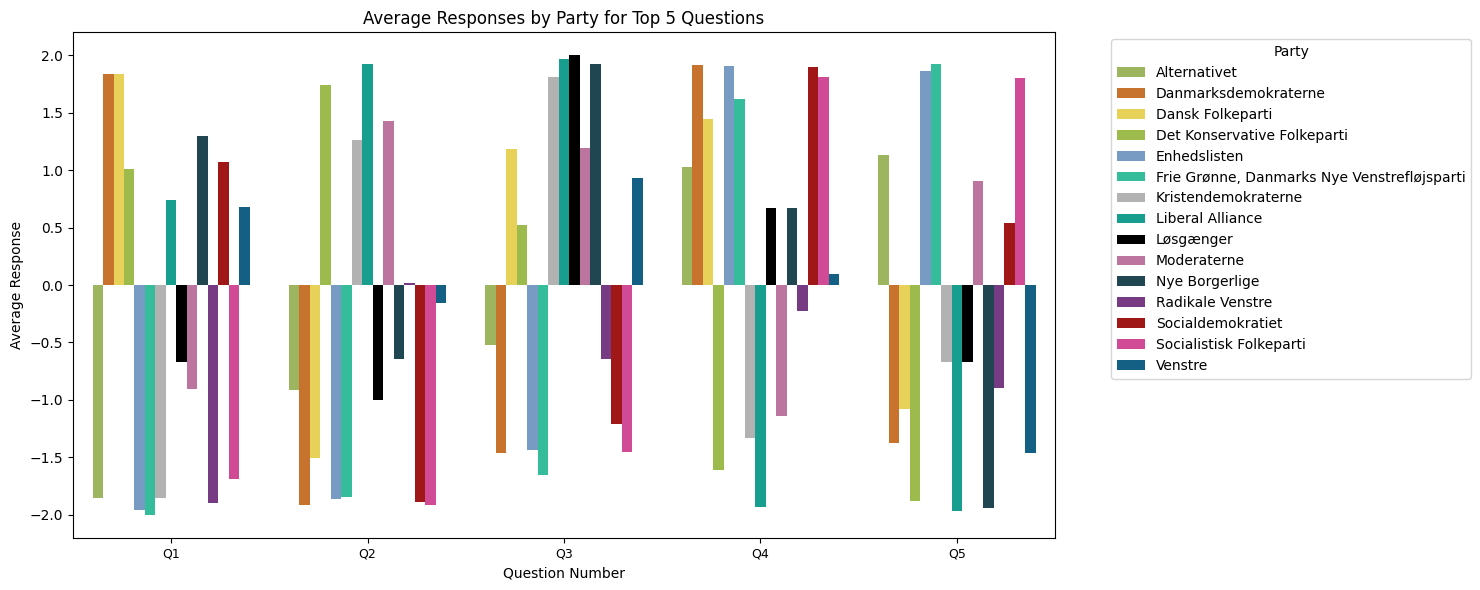

In [31]:
print("Top 5 Questions - Printing first for better readbility:")
question_mapping = {}
for i, question in enumerate(top_crutial_questions, 1):
    question_mapping[question] = f"Q{i}"
    print(f"Q{i}: {question}")

party_averages_top5 = party_averages[top_crutial_questions]

long_format_top5 = party_averages_top5.reset_index().melt(id_vars="parti", var_name="Question", value_name="Average Response")
long_format_top5["Question"] = long_format_top5["Question"].map(question_mapping)

plt.figure(figsize=(15, 6))
sns.barplot(
    data=long_format_top5,
    x="Question",
    y="Average Response",
    hue="parti",
    palette=party_colors
)

plt.title("Average Responses by Party for Top 5 Questions", fontsize=12)
plt.xlabel("Question Number", fontsize=10)
plt.ylabel("Average Response", fontsize=10)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=10)
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Step 10 - Lets do Clustering

But why clustering ?
Each candidate's answers reflect their political views. Clustering groups candidates who have similar answers, which likely means they agree on certain political issues.

By analyzing these clusters, we can try to determine if have:
- Fewer clusters (groups of similar candidates) would suggest that certain parties might have similar views and could be merged.
- More clusters would suggest distinct groups within existing parties, potentially indicating a need for more specialized parties.

### Lets start with K-Means

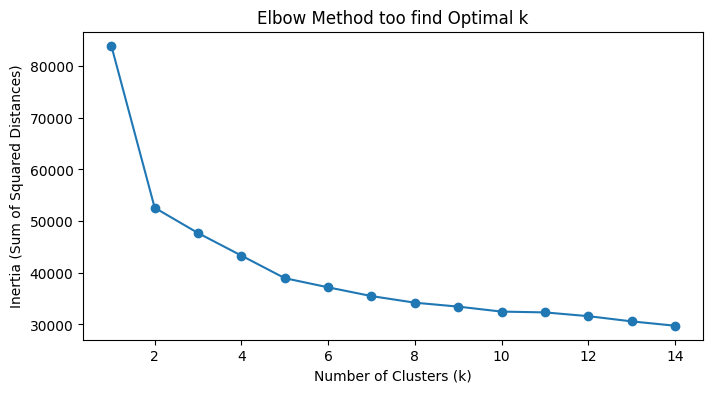

In [32]:
# Step 1 - Standardize the data using Scaling (because its datance based): 
# We don't need to do scaling here, as the answers are Likert scale.


# Step 2 - What should K be ?
# It's easier if you an expert in the domain, but we can use elbow method to find the optimal K here: 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []
k_values = range(1, 15) # Lets try with 1 to 15 different values.

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(answers)  
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method too find Optimal k")
plt.show()

c:\Users\Ola\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


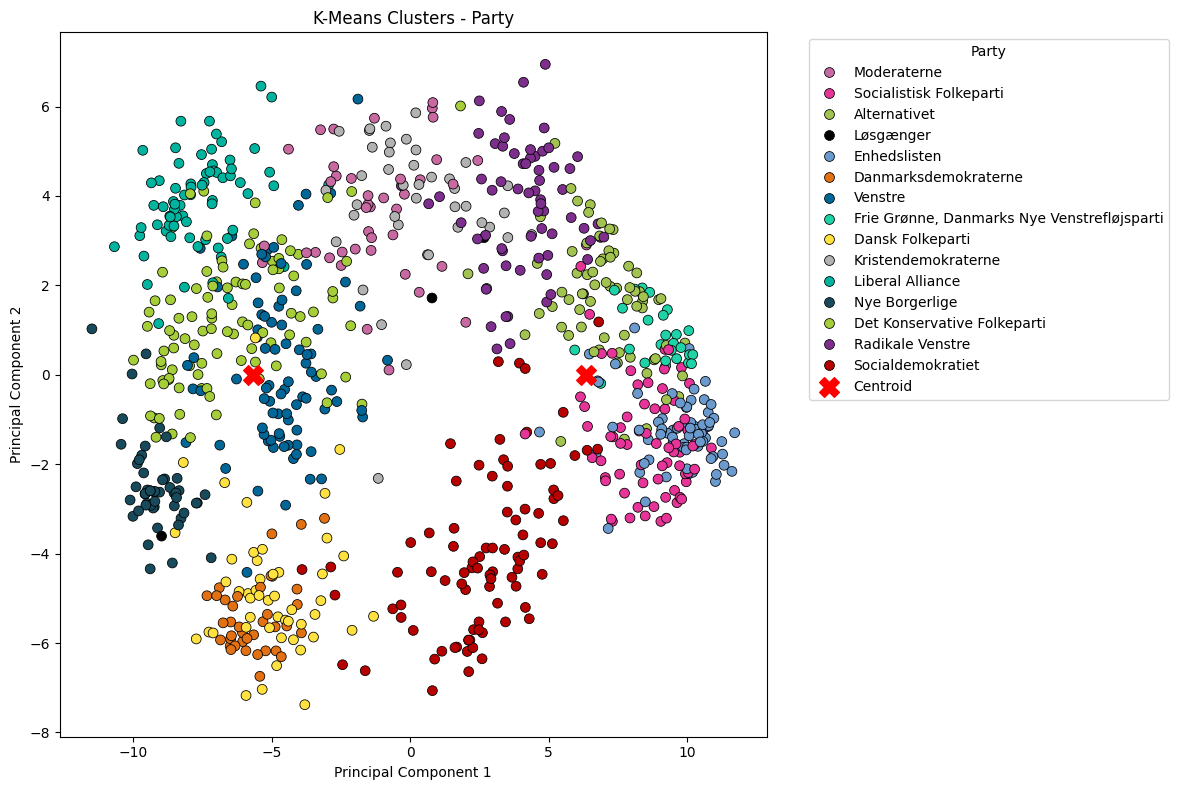

In [33]:
# Step - 3 Fit K-Means with optimal k and visualize it. 

optimal_k = 2  # As per above Elbow, we get 2 as best k.
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(answers)  # Assign clusters to each candidate


from sklearn.decomposition import PCA

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(answers)

results = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
results['Cluster'] = clusters
results['Party'] = segments['parti'].values

results['PartyColor'] = results['Party'].map(party_colors)

# Get the centroids in the original feature space and transform them to PCA space
centroids = kmeans.cluster_centers_  # Centroids in the original feature space
centroids_pca = pca.transform(centroids)  # Project centroids to PCA space

# Plot clusters with colors representing parties
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results, x='PC1', y='PC2', hue='Party', palette=party_colors, s=50, edgecolor='k', legend='full')

# Add centroids to the plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroid')

plt.title("K-Means Clusters - Party")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There are two broad groups with some internal divisions.
More clusters might be needed to capture more distinctions.. Lets try with K = 5

c:\Users\Ola\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


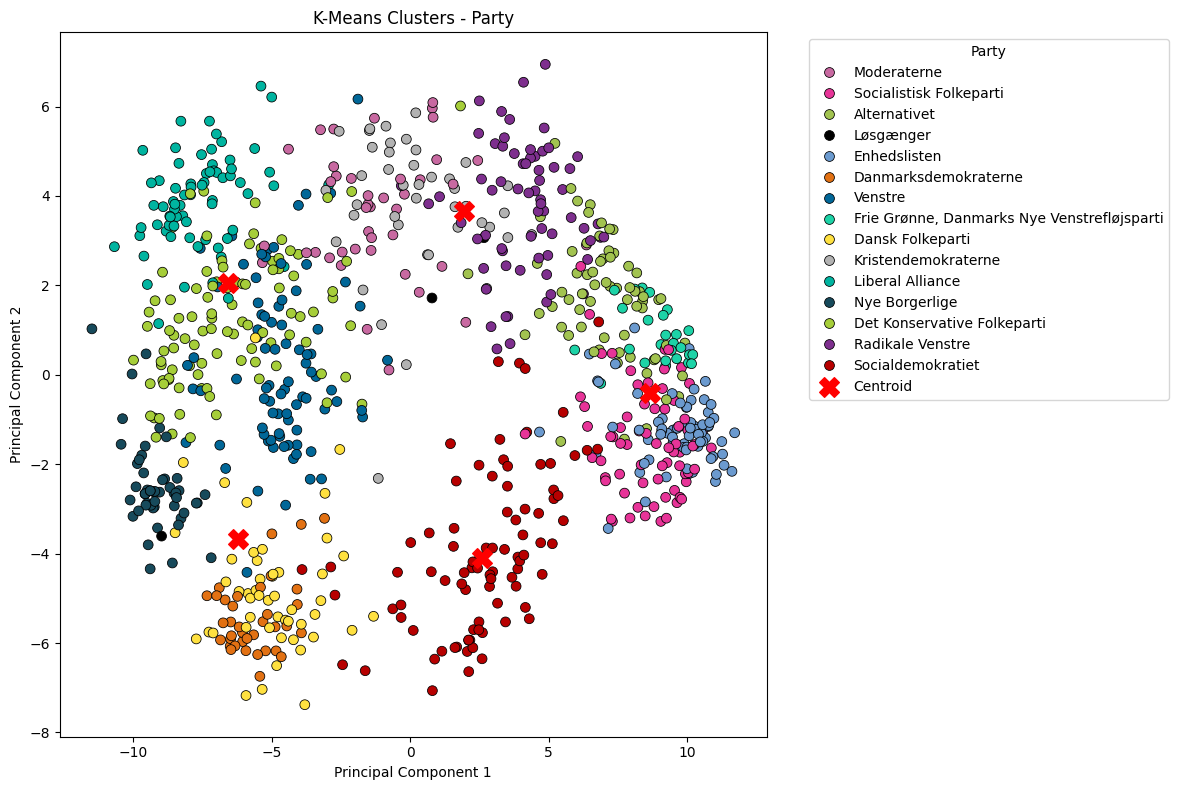

In [34]:
optimal_k = 5 # As per above Elbow, we get 2 as best k.
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(answers)  # Assign clusters to each candidate

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(answers)

results = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
results['Cluster'] = clusters
results['Party'] = segments['parti'].values

results['PartyColor'] = results['Party'].map(party_colors)

# Get the centroids in the original feature space and transform them to PCA space
centroids = kmeans.cluster_centers_  # Centroids in the original feature space
centroids_pca = pca.transform(centroids)  # Project centroids to PCA space

# Plot clusters with colors representing parties
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results, x='PC1', y='PC2', hue='Party', palette=party_colors, s=50, edgecolor='k', legend='full')

# Add centroids to the plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroid')

plt.title("K-Means Clusters - Party")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Conclusion of K-Means Analysis
At this point, K-Means has provided valuable insights into how the candidates cluster and how well these clusters align with existing parties.

- Socialdemokratiet have internal consistency. They remain strong 
- Dansk Folkeparti, and Danmarksdemokraterne seem very similar in their responses. This suggests, they could possibly be merged ...
- There is also a lot of overlap amongs parties.. indicating similarity.

### Let's move on to Hierarchical Clustering:

This method will help us see how candidates cluster together in a tree-like structure, allowing us to identify natural splits in the data.


Hierarchical Clustering is a method that builds a tree-like structure to show how data points, in this case, candidates can be grouped together based on their similarity. 

Agglomerative --Bottom-Up: Start with each data point as its own cluster, then merge the closest clusters until everything is in one big cluster. We will focus on this type..

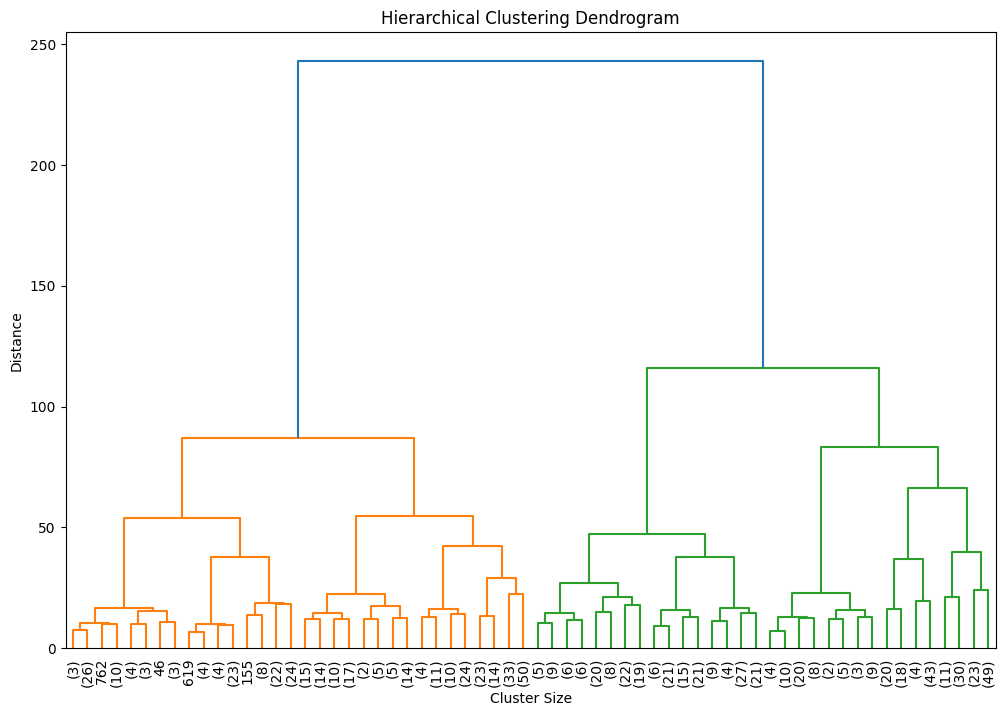

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(answers, method='ward')  # Using Ward's method -- The increase in cost when merging.

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Show only a certain level of the tree for readability
    p=5,                    # Only the last 5 levels of the tree will be shown
    leaf_rotation=90,       # Rotate labels
    leaf_font_size=10,      # Font size for labels
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


Lets now cut at the 100 level to get 4 clusters. This should give us good level of detail, capturing some diversity within the data without creating too many clusters to analyze effectively.

Plan: 
- Assign Clusters to Each Candidate:
    Cluster the data based on each candidate's responses, so each candidate is assigned a cluster.
    This approach allows us to see which individual candidates fall into similar opinion groups.

- Analyze Cluster Composition by Party:
    After assigning clusters, we count the number of candidates from each party within each cluster. This will help us determine if certain clusters are dominated by specific parties or if parties are spread across multiple clusters. This step helps us understand party cohesion and cross-party alignment.

In [36]:
# Count of candidates from each party in each cluster

from scipy.cluster.hierarchy import fcluster

# Cutting the dendrogram at the 100 level based on above.
n_clusters = 4 

clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  # Use 'maxclust' to specify number of clusters

# Add clusters and party names to the data for analysis
results = answers.copy()  # Create a copy of answers for analysis
results['Cluster'] = clusters
results['Party'] = segments['parti'].values  # Add party names from `segments`
results['Candidate'] = segments['navn'].values  # Add candidate names for reference

# Group by clusters and count the number of candidates from each party in each cluster
cluster_analysis = results.groupby(['Cluster', 'Party']).size().unstack(fill_value=0)

cluster_analysis

Party,Alternativet,Danmarksdemokraterne,Dansk Folkeparti,Det Konservative Folkeparti,Enhedslisten,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Kristendemokraterne,Liberal Alliance,Løsgænger,Moderaterne,Nye Borgerlige,Radikale Venstre,Socialdemokratiet,Socialistisk Folkeparti,Venstre
Cluster,,,,,,,,,,,,,,,
1,0,35,47,1,0,0,0,2,1,0,50,0,0,0,2
2,0,2,2,95,0,0,0,68,0,2,1,0,0,0,81
3,55,0,0,0,73,26,1,0,0,1,0,1,0,62,0
4,12,0,0,2,1,0,41,0,2,39,0,66,87,8,1


In Cluster 1 we see: 
35 candidates from Dansk Danmarksdemokraterne. 
47 candidates from Dansk Folkeparti.
50 candidates from Nye Borgerlige
This suggests that these three parties have similar responses, as many of their members ended up in the same cluster.

In Cluster 2 is dominated by Det Konservative Folkeparti, Liberal Alliance and Venstre with 95, 68 and 81 members, respectively. This also indicate some shared viewpoints between these groups.

The table shows which parties stick together (most members in one group) and which are split into several groups (showing more variety within the party).

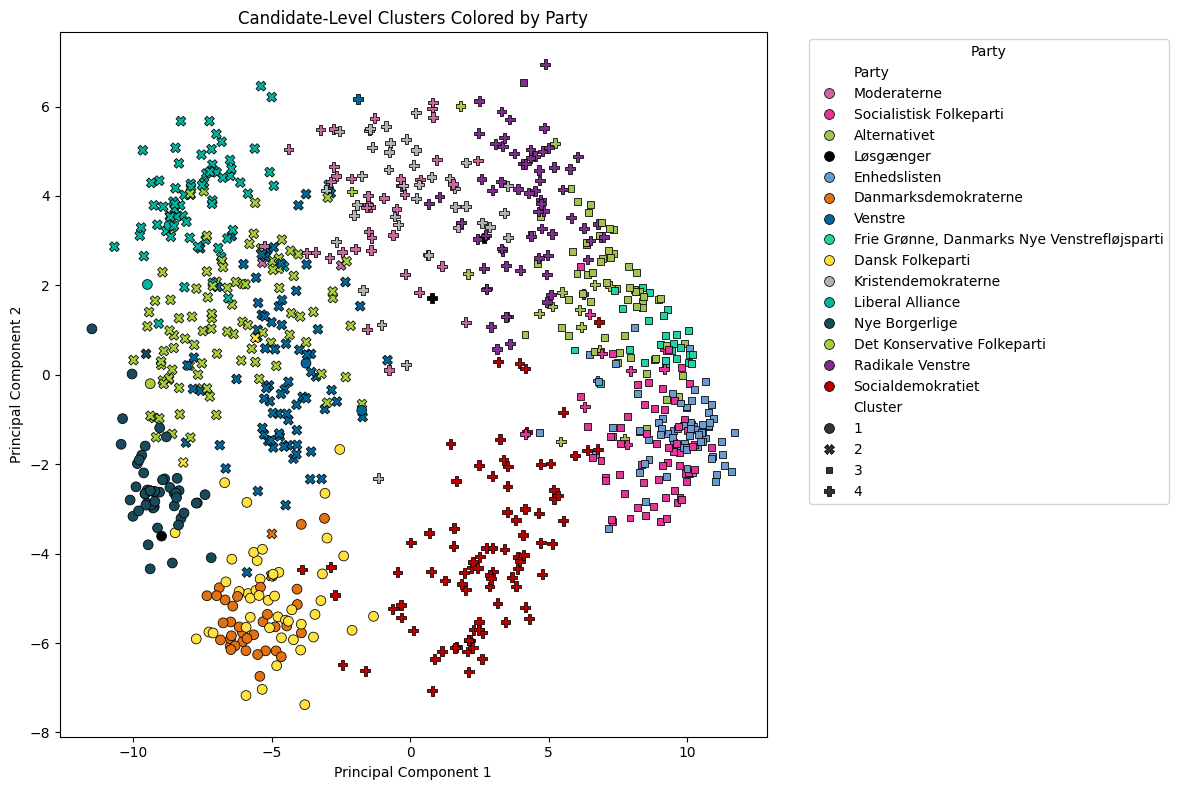

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(answers)

# Create a DataFrame for visualization
results_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
results_pca['Cluster'] = clusters
results_pca['Party'] = results['Party']  # Add party info
results_pca['Candidate'] = results['Candidate']  # Add candidate names for reference

# Plot with each candidate's cluster and color by party
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_pca, x='PC1', y='PC2', hue='Party', style='Cluster', palette=party_colors, s=50, edgecolor='k', legend='full')
plt.title("Candidate-Level Clusters Colored by Party")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Each point represents a candidate.
- Color represents the candidate's party.
- Marker shapes represent the cluster assigned to that candidate.

Key observations:
Party Unity vs. Diversity:
- Some parties are tightly grouped around a particular cluster. For example, Socialdemokratiet in red seems mostly aligned with Cluster 4.
- Dansk Folkeparti (yellow), Danmarksdemokraterne (Orange) and Nye Borerlige (dark blue) appear concentrated around Cluster 1 which shows common view points.
- Det Konservatie Folkeparti shows spread among various Clusters, it indicates divese viewpoints within the party.

### Step 11 - DBSCAN

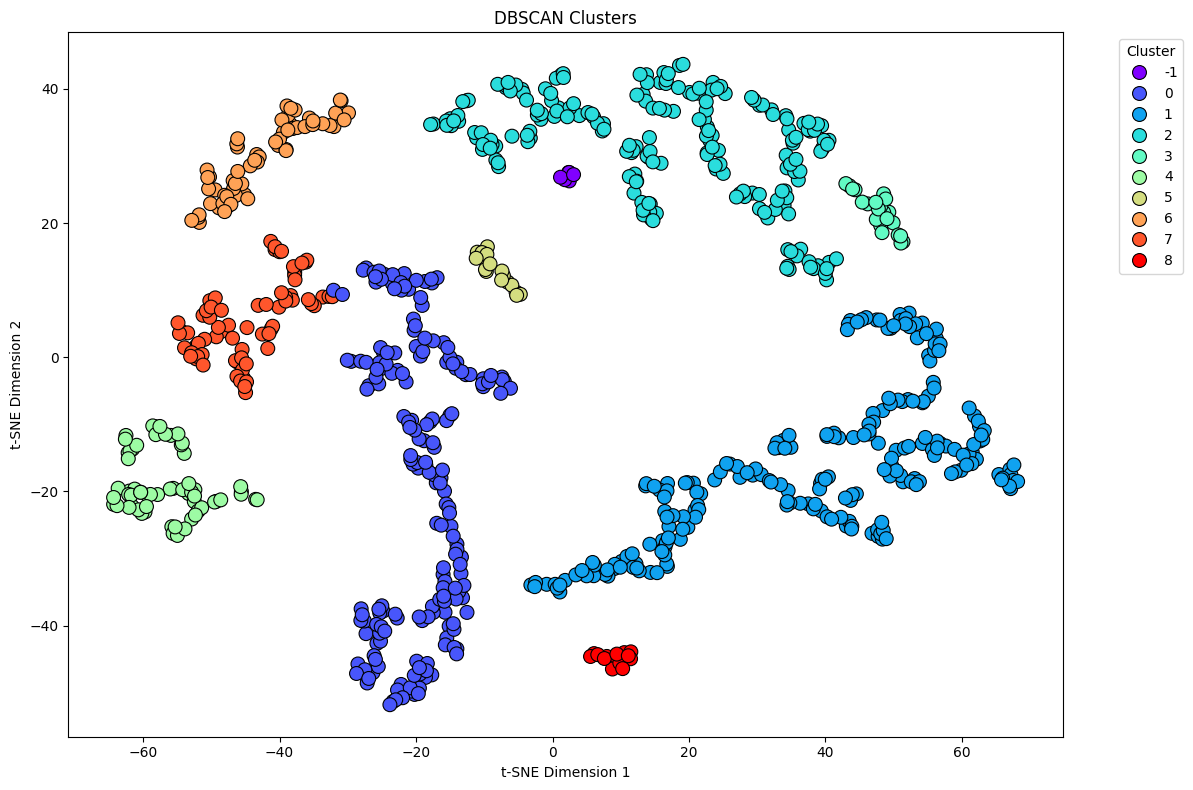

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import numpy as np

# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2, random_state=10)  # Retain the top 50 components (adjust as needed)
X_pca = pca.fit_transform(answers)

# Reduce dimensions further using t-SNE
tsne = TSNE(n_components=2, perplexity=11, random_state=10)
X_tsne = tsne.fit_transform(X_pca)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=6, min_samples=15)
clusters = dbscan.fit_predict(X_tsne)

# Create a DataFrame for visualization
results_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
results_tsne['Cluster'] = clusters  # Add DBSCAN cluster labels


# Generate rainbow colors for clusters
unique_clusters = np.sort(results_tsne['Cluster'].unique())
n_clusters = len(unique_clusters)
colors = cm.rainbow(np.linspace(0, 1, n_clusters))  # Generate colors from the rainbow colormap
palette = [colors[i] for i in range(n_clusters)]

# Plot the t-SNE-reduced data
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results_tsne,
    x='Dim1', 
    y='Dim2', 
    hue='Cluster',  # Use colors for clusters
    palette=palette,  # Provide a list of colors
    s=100, 
    edgecolor='k', 
    legend='full'
)
plt.title("DBSCAN Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
